# Molecular dynamics simulation

## Overview


### Questions

- How can one set up a simple molecular dynamics (MD) simulation with a polymer?

### Objectives


- Demonstrate the effect of integration step size on energy conservation in an NVE ensemble.

## Workflow

### Import packages
Let's import the packages needed for the job.

In [1]:
import gsd.hoomd
import hoomd
import matplotlib
import numpy as np

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

A function named `render` is defined in the cell below to create visualizations using fresnel. The cell may be hidden.

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import math
import warnings
import os

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.material.primitive_color_mix = 1
    geometry.position[:] = snapshot.particles.position[:]
    typeid = snapshot.particles.typeid
    geometry.color[typeid == 1, :] = fresnel.color.linear(
        [90 / 255, 226 / 255, 75 / 255]
    )
    geometry.color[typeid == 0, :] = fresnel.color.linear(
        [255 / 255, 154 / 255, 202 / 255]
    )

    geometry.outline_width = 0.08
    fresnel.geometry.Box(scene, [L, L, 0, 0, 0, 0], box_radius=0.08)

    scene.lights = [
        fresnel.light.Light(
            direction=(1, 0, 0.4), color=(0.85, 0.85, 0.85), theta=math.pi / 2
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L + 2
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

### Building the polymer
For this tutorial, we will use a single polymer chain. Let's build a linear polymer with $N$ monomers in a cubic box of length, $L$. The polymer is oriented along the $x-\text{axis}$ and centered in the box. The output is saved in a GSD file, `polymer.gsd`.

We should make sure the file does not already exist in our directory.

In [3]:
file = os.path.join(os.getcwd(), "polymer.gsd")
if os.path.exists(file):
    os.remove(file)

In [4]:
L = 100
N = 30
bond = 1.0
positions = np.zeros((N, 3), dtype=float)
for i in range(N):
    positions[i, 0] = i * bond - ((N * bond - 1) * 0.5)

frame = gsd.hoomd.Frame()
frame.configuration.box = [L, L, L, 0, 0, 0]

# beads
frame.particles.N = N
frame.particles.position = positions
frame.particles.typeid = np.zeros(frame.particles.N, dtype=int)
frame.particles.types  = ["A"]
frame.particles.mass   = np.full(frame.particles.N, 1.0) 

# bonds
frame.bonds.N = N - 1
frame.bonds.typeid = np.zeros(frame.bonds.N, dtype=int)
frame.bonds.types = ["A"]
frame.bonds.group = np.column_stack((range(0, N - 1), range(1, N)))

with gsd.hoomd.open("polymer.gsd", "w") as f:
    f.append(frame)

Let's use the `render` function to view the polymer chain.

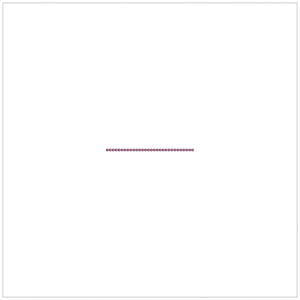

In [5]:
render(frame)

### Running the simulation

Next up, we are going to load the polymer, relax the system and run a simulation.

In [6]:
dt = 0.005

dev = hoomd.device.CPU()
with gsd.hoomd.open("polymer.gsd") as traj:
    frame = traj[-1] # if there are multiple frames, you may want to use the last one

# create starting snapshot
snapshot = hoomd.Snapshot.from_gsd_frame(frame, dev.communicator)

We can make another call to `render` to view our relaxed system before we proceed to production.

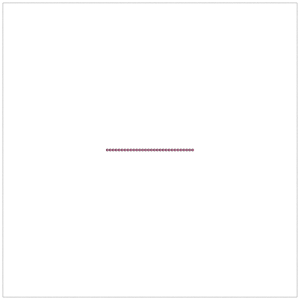

In [7]:
render(snapshot)

We also need to initialize the simulation state and select an integration method. Since we are interested in the NVE ensemble, we will use [`hoomd.md.methods.ConstantVolume`](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/methods/constantvolume.html) with no thermostat.

Remember to add the integration method to `operations`. 

In [8]:
simulation = hoomd.Simulation(device=dev, seed=42)
simulation.create_state_from_snapshot(snapshot)

# assign gaussian distributed velocities
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

integrator = hoomd.md.Integrator(dt=dt)
simulation.operations.integrator = integrator

nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(nve)

We will use the Finite Extensible Nonelastic (FENE) potential, with Kremer-Grest parameters for our polymer.

$$
U_{\text{FENE}}(r) = -\dfrac{1}{2} k r_0^2 \ln \left[ 1 - \left( \dfrac{r}{r_0} \right)^2 \right]
$$

where:
- $r$ is the distance between the bonded particles,
- $k$ is the strength of the attractive force,
- $r_0$ is the maximum bond extension (beyond which the force becomes infinite and breaks).

A Weeks-Chandler-Andersen (WCA) potential is also incorporated to model the repulsive interactions.

$$
U_{\text{WCA}}(r) =
\begin{cases}
4\varepsilon \left[ \left( \dfrac{\sigma}{r} \right)^{12} - \left( \dfrac{\sigma}{r} \right)^6 \right] + \varepsilon, & r \leq 2^{1/6} \sigma \\
0, & r > 2^{1/6} \sigma
\end{cases}
$$

where:
- $\varepsilon$ is the repulsive interaction energy,
- $\sigma$ is the repulsive interactive width.

HOOMD-blue's `FENEWCA()` method will do this for bonded pairs and we will define a sWCA potential to handle non-bonded pairs.

In [9]:
fenewca = hoomd.md.bond.FENEWCA()
fenewca.params["A"] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)
integrator.forces.append(fenewca)

nl = hoomd.md.nlist.Tree(buffer=1.0, exclusions=["bond"])
wca = hoomd.md.pair.LJ(nlist=nl, default_r_cut=2.0 ** (1.0 / 6.0), mode="shift")
wca.params[("A", "A")] = dict(sigma=1.0, epsilon=1.0)
integrator.forces.append(wca)

Let's complete the simulation setup with one more thing - an output log of our thermodynamic quantities of interest. A list of thermodynamic quantities that can be computed are available [on this page](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/compute/thermodynamicquantities.html).

In [10]:
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())

We will create the logger following the documentation [here](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/logging/logger.html). Since our output quantities of interest are all **scalars**, we will only have that in our category list. The items to log are:
- time (which is within the `simulation` object so it will be added from there)
- kinetic energy, potential energy and kinetic temperature (which will be added from the `thermo` object computed)

In [11]:
logger = hoomd.logging.Logger(categories=["scalar"])
logger.add(obj=simulation, quantities=["timestep"])
logger.add(obj=thermo, quantities=["kinetic_energy","potential_energy","kinetic_temperature"])

The created `logger` will be written to file as a `Table`.

In [12]:
output_log = open(f"thermo-{dt}.dat", "w")
table = hoomd.write.Table(
    trigger=1_000,
    logger=logger,
    output=output_log,
    max_header_len=7
)

We shouldn't forget to append our `compute` and `logger` to `operations`.

In [13]:
simulation.operations.computes.append(thermo)
simulation.operations.writers.append(table)

Trajectory information can also be saved in a `GSD` file for visualization. Note that, a logger, such as the one defined above, can also be added to a GSD file but let's keep things as they are now, for simplicity.

In [14]:
# save GSD output
gs = hoomd.write.GSD(
    trigger=10_000,
    filename="production-"+str(dt)+".gsd",
    mode="wb",
    dynamic=["property", "particles/velocity", "particles/image"]
)
simulation.operations.writers.append(gs)

We should now set the number of steps and run the simulation.

In [15]:
nsteps = 20_000_000
simulation.run(nsteps, write_at_start=True)
gs.flush()

To conveniently run simulations of different instances of the integration step size, $\Delta t$, the blocks of code presented above can be put together into a single function; let's call ours `nve_simulation`. The next cell (which might be hidden) shows this.

In [16]:
def nve_simulation(dt, steps):

    # load polymer
    dev = hoomd.device.CPU()
    with gsd.hoomd.open("polymer.gsd") as traj:
            frame = traj[-1]

    snapshot = hoomd.Snapshot.from_gsd_frame(frame, dev.communicator)

    # initialize simulation from snapshot
    simulation = hoomd.Simulation(device=dev, seed=42)
    simulation.create_state_from_snapshot(snapshot)

    # assign gaussian distributed velocities
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

    integrator = hoomd.md.Integrator(dt=dt)
    simulation.operations.integrator = integrator

    nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
    integrator.methods.append(nve)

    # FENE + WCA
    fenewca = hoomd.md.bond.FENEWCA()
    fenewca.params["A"] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)
    integrator.forces.append(fenewca)

    nl = hoomd.md.nlist.Tree(buffer=1.0, exclusions=["bond"])
    wca = hoomd.md.pair.LJ(nlist=nl, default_r_cut=2.0 ** (1.0 / 6.0), mode="shift")
    wca.params[("A", "A")] = dict(sigma=1.0, epsilon=1.0)
    integrator.forces.append(wca)

    # create logger
    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    logger = hoomd.logging.Logger(categories=["scalar"])
    logger.add(simulation, quantities=["timestep"])
    logger.add(thermo, quantities=["kinetic_energy","potential_energy","kinetic_temperature"])
    output_log = open(f"thermo-{dt}.dat", "w")
    table = hoomd.write.Table(
        trigger=1_000,
        logger=logger,
        output=output_log,
        max_header_len=7
    )

    simulation.operations.computes.append(thermo)
    simulation.operations.writers.append(table)

    # save output
    gs = hoomd.write.GSD(
        trigger=10_000,
        filename="production-"+str(dt)+".gsd",
        mode="wb",
        dynamic=['property','particles/velocity','particles/image']
    )
    simulation.operations.writers.append(gs)

    # production
    simulation.run(steps, write_at_start=True)
    gs.flush()

Having completed a run with $\Delta t = 0.005$, let us also consider $\Delta t = 0.001\ \text{and}\ 0.009$.

In [17]:
for dt in [0.001, 0.009]:
    nve_simulation(dt, nsteps)

### Analyzing the results

We will analyze the simulation results for energy conservation with all cases of $\Delta t$.
The measure of energy conservation will be the root-mean-squared deviation. 

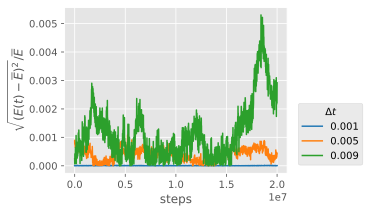

The mean error using Δt = 0.001 is 0.0000.
The mean error using Δt = 0.005 is 0.0004.
The mean error using Δt = 0.009 is 0.0011.


In [18]:
dt = [0.001, 0.005, 0.009]

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(4, 3))
cmap = matplotlib.pyplot.get_cmap("tab10")
colors = [cmap(i) for i in range(len(dt))]

averages = np.zeros((len(dt)))

for i, t in enumerate(dt):
    data = np.loadtxt(f"thermo-{t}.dat", skiprows=1)
    tot_e = data[:, 1] + data[:, 2]
    dev = tot_e - np.mean(tot_e)
    yval = np.sqrt(dev**2) / np.mean(tot_e)
    ax.plot(data[::10, 0], yval[::10], color=colors[i], label="%s"%t)

    averages[i] = np.mean(yval) 

ax.set_ylabel(r"$\sqrt{(E(t)-\overline{E})^{2}}/\overline{E}$")
ax.set_xlabel("steps")
ax.legend(loc=(1.05,0.05), title=r"$\Delta t$")
matplotlib.pyplot.show()

for i, t in enumerate(dt):
    print(f"The mean error using Δt = {t} is {averages[i]:.4f}.")

From these results, energy is conserved for $\Delta t = 0.001\ \text{and}\ 0.005$. So, let's compare other thermodynamic quantities using $\Delta t = 0.005\ \text{and}\ 0.009$, starting with the potential energy. 

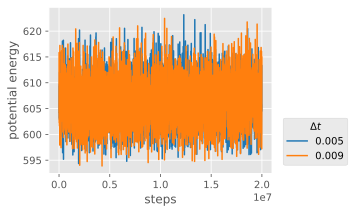

In [19]:
dt = [0.005, 0.009]

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(4, 3))
cmap = matplotlib.pyplot.get_cmap("tab10")
colors = [cmap(i) for i in range(len(dt))]

for i, t in enumerate(dt):
    data = np.loadtxt(f"thermo-{t}.dat", skiprows=1)
    ax.plot(data[::5, 0], data[::5, 2], color=colors[i], label="%s"%t)
ax.set_ylabel("potential energy")
ax.set_xlabel("steps")
ax.legend(loc=(1.05,0.05), title=r"$\Delta t$")
matplotlib.pyplot.show()

And then the kinetic temperature.

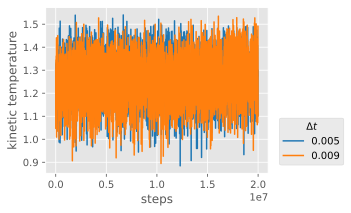

In [20]:
dt = [0.005, 0.009]

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(4, 3))
cmap = matplotlib.pyplot.get_cmap("tab10")
colors = [cmap(i) for i in range(len(dt))]

for i, t in enumerate(dt):
    data = np.loadtxt(f"thermo-{t}.dat", skiprows=1)
    ax.plot(data[::5, 0], data[::5, 3], color=colors[i], label="%s"%t)
ax.set_ylabel("kinetic temperature")
ax.set_xlabel("steps")
ax.legend(loc=(1.05,0.05), title=r"$\Delta t$")
matplotlib.pyplot.show()

Well, we could also examine momentum conservation in all directions. Since all particles have an equal mass of 1.0, we will sum up velocities. Velocities were saved in the `GSD` file so we will load from there.

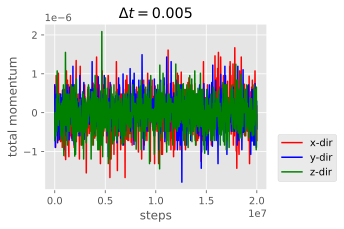

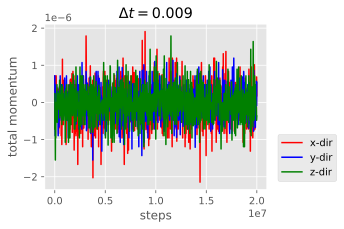

In [21]:
dt = [0.005, 0.009]

for _, t in enumerate(dt):
    fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(4, 3))
    with gsd.hoomd.open(f"production-{t}.gsd") as traj:
        mom = np.zeros((len(traj), 3), dtype=float)
        time = np.zeros((len(traj)))
        for i, frame in enumerate(traj):
            mom[i, :] = np.sum(frame.particles.velocity[:], axis=0)
            time[i] = frame.configuration.step
    ax.plot(time[::2], mom[::2, 0], color="red", label="x-dir")
    ax.plot(time[::2], mom[::2, 1], color="blue", label="y-dir")
    ax.plot(time[::2], mom[::2, 2], color="green", label="z-dir")

    ax.set_title(fr"$\Delta t={t} $")
    ax.set_ylabel("total momentum")
    ax.set_xlabel("steps")
    ax.legend(loc=(1.05,0.05))
    matplotlib.pyplot.show()